In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.color'], mpl.rcParams['axes.labelcolor'], mpl.rcParams['xtick.color'], mpl.rcParams['ytick.color'] = ['white']*4

In [6]:
class NaiveBayesClf:
    def __init__(self, algo='gaussian', alpha=None):
        '''
        algo:str - 'gaussian': For normal distribution, Used for classification.
                   'multinomial': For multinomially distributed data
                   'bernoulli': used when feature vectors are binary
                   'complement': Adaptation of the standard Multinomial Naive Bayes (MNB) algorithm 
                       that is particularly suited for imbalanced data sets wherein the algorithm 
                       uses statistics from the complement of each class to compute the model’s weight.
        alpha:float - for 'gaussian' algorithm, alpha is the 
                        for 'multinomial' algorithm, if alpha=1, Laplace smoothing
                                        elif alpha < 1, Lidstone smoothing
                                        else alpha >= 0, prevents zero probabilities
        '''
        if algo == 'gaussian':
            self.algo = algo
            if alpha is None:
                alpha = 1e-9
            self.alpha = alpha
        elif algo == 'multinomial':
            self.algo = algo
            if alpha is None:
                alpha = 1.0
            self.alpha = alpha

    def train(self, X, y):
        '''
        X - (n_datapoints, n_features)
        y - (n_datapoints, 1)
        '''
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        n_datapoints, n_features = X.shape
        assert len(y) == n_datapoints
        y = y.reshape(-1)
        # Frequency Table / Prior probabilities
        classes = np.unique(y)
        n_classes = len(classes)
        priors = np.zeros((n_classes, 1))
        mu = np.zeros((n_classes, n_features))
        sigma2 = np.zeros((n_classes, n_features))
        # ith class features will be stored in ith index
        features_by_class = []
        for i in range(n_classes):
            features_by_class.append(X[y==classes[i], :])
            priors[i] = len(features_by_class[-1]) / n_datapoints
            mu[i] = features_by_class[-1].mean(axis=0)
            sigma2[i] = features_by_class[-1].var(axis=0)
        self.n_classes = n_classes
        self.priors = priors
        self.mu = mu
        self.sigma2 = sigma2 + self.alpha * np.var(X, axis=0).max()    # To avoid numerical error (from sklearn source)
    
    def predict(self, X, return_probs=False):
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if self.algo == 'gaussian':
            cond_prob = np.zeros((self.n_classes, X.shape[0]))
            for i in range(self.n_classes):
                cond_prob[i, :] = (np.exp(-((X-self.mu[i])**2 / (2 * self.sigma2[i]))) / np.sqrt(2*np.pi*self.sigma2[i])).prod(axis=1)
            probs = self.priors * cond_prob
            yp = probs.argmax(axis=0)
        elif self.algo == 'multinomial':
            pass
        else:
            raise NotImplementedError
        if return_probs:
            return yp, probs
        return yp
    
    @staticmethod
    def score(y, y_pred):
        return 100 * (y==y_pred).sum() / len(y)

In [ ]:
class GaussianNB:
    def __init__(self, ):
        super().__init__(algo='gaussian')
class BernoulliNB:
    def __init__(self, ):
        super().__init__(algo='bernoulli')
class MultinomialNB:
    def __init__(self, ):
        super().__init__(algo='multinomial')
class ComplementNB:
    def __init__(self, ):
        super().__init__(algo='complement')

# Comparing with sklearn module

### Helper function to compare and plot

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix
def pipe(X, y, models, feature=None, fit_prior=True, normalize=False, norm_method="fro", alpha=1, test_size=0.3):
#     plt.figure(figsize=(10,15))
#     plot_X = X
#     if X.ndim == 2:
#         if X.shape[1] > 1:
#             if feature is None:
#                 print("Supported only for 1 feature, ignoring other features for plotting")
#                 plot_X = X[:, 0].reshape(-1, 1)
#             else:
#                 plot_X = X[:, feature].reshape(-1, 1)
#     plt.scatter(plot_X, y, color='black')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    for k in models:
        print(k)
        if 'sk' in k:
            models[k].fit(X_train, y_train)
        else:
            if normalize:
                X_train = Normalizer(method=norm_method).normalize(X_train)
                X_test = Normalizer(method=norm_method).normalize(X_test)
            models[k].train(X_train, y_train)

        y_pred = models[k].predict(X)
        print("-"*20, k, "-"*20)
        print("sklearn Accuracy scores ---------")
        print("Test Accuracy score = ", accuracy_score(y_test, models[k].predict(X_test)))
        print("Whole dataset Accuracy score = ", accuracy_score(y, y_pred))
        print("My Accuracy scores ---------")
        print("Test Accuracy score = ", NaiveBayesClf().score(y_test, models[k].predict(X_test)))
        print("Whole dataset Accuracy score = ", NaiveBayesClf().score(y, y_pred))
    return models

In [12]:
X = np.array([1, 2, 5, 3, 2, 2, 1, 5, 5, 1, 3]).reshape(-1, 1)
y = np.array([1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0])

In [8]:
from sklearn import datasets, linear_model
X, y = datasets.load_diabetes(return_X_y=True)

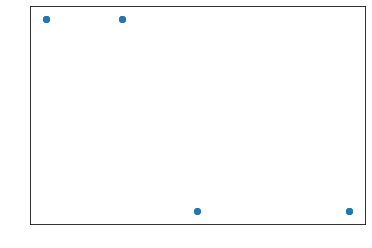

In [14]:
plt.scatter(X, y)

In [9]:
X.min(), X.max()

(-0.137767225690012, 0.198787989657293)

In [10]:
import sklearn.naive_bayes as sknb
models = {
    'skGNB': sknb.GaussianNB(),
    'myGNB': NaiveBayesClf(algo='gaussian')
}
models = pipe(X, y, models)

skGNB
-------------------- skGNB --------------------
sklearn Accuracy scores ---------
Test Accuracy score =  0.0
Whole dataset Accuracy score =  0.45701357466063347
My Accuracy scores ---------
Test Accuracy score =  0.0
Whole dataset Accuracy score =  45.70135746606335
myGNB
-------------------- myGNB --------------------
sklearn Accuracy scores ---------
Test Accuracy score =  0.007518796992481203
Whole dataset Accuracy score =  0.0022624434389140274
My Accuracy scores ---------
Test Accuracy score =  0.7518796992481203
Whole dataset Accuracy score =  0.22624434389140272


In [98]:
models['skGNB'].sigma_

array([[2.46267984e-12, 2.46267984e-12, 2.46267984e-12, ...,
        2.46267984e-12, 2.46267984e-12, 2.46267984e-12],
       [2.46267984e-12, 2.46267984e-12, 2.46267984e-12, ...,
        2.46267984e-12, 2.46267984e-12, 2.46267984e-12],
       [2.46267984e-12, 2.46267984e-12, 2.46267984e-12, ...,
        2.46267984e-12, 2.46267984e-12, 2.46267984e-12],
       ...,
       [2.46267984e-12, 2.46267984e-12, 2.46267984e-12, ...,
        2.46267984e-12, 2.46267984e-12, 2.46267984e-12],
       [2.46267984e-12, 2.46267984e-12, 2.46267984e-12, ...,
        2.46267984e-12, 2.46267984e-12, 2.46267984e-12],
       [2.46267984e-12, 2.46267984e-12, 2.46267984e-12, ...,
        2.46267984e-12, 2.46267984e-12, 2.46267984e-12]])

In [99]:
models['myGNB'].sigma2

array([[2.46267984e-12, 2.46267984e-12, 2.46267984e-12, ...,
        2.46267984e-12, 2.46267984e-12, 2.46267984e-12],
       [2.46267984e-12, 2.46267984e-12, 2.46267984e-12, ...,
        2.46267984e-12, 2.46267984e-12, 2.46267984e-12],
       [2.46267984e-12, 2.46267984e-12, 2.46267984e-12, ...,
        2.46267984e-12, 2.46267984e-12, 2.46267984e-12],
       ...,
       [2.46267984e-12, 2.46267984e-12, 2.46267984e-12, ...,
        2.46267984e-12, 2.46267984e-12, 2.46267984e-12],
       [2.46267984e-12, 2.46267984e-12, 2.46267984e-12, ...,
        2.46267984e-12, 2.46267984e-12, 2.46267984e-12],
       [2.46267984e-12, 2.46267984e-12, 2.46267984e-12, ...,
        2.46267984e-12, 2.46267984e-12, 2.46267984e-12]])

## Predict
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/1eaed580cf7c29f044a9e517f1cd4a7dd69c4b1f" style="background-color: white">

## Gaussian naive Bayes
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/685339e22f57b18d804f2e0a9c507421da59e2ab" style="background-color: white">

## Multinomial naive Bayes
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/0bf7b8e6edae7359863977eca136558ce5b68568" style="background-color: white">
<pre>Many conditional probabilities are multiplied, one for each feature. This can result in a floating point underflow. It is therefore better to perform the computation by adding logarithms of probabilities instead of multiplying probabilities. The class with the highest log probability score is still the most probable
</pre>
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/e53303c0644c3d64e5eb86210023e76198285e0c" style="background-color: white">

## Bernoulli naive Bayes
<img src="">